# 22b: Domino Co-occurrence Matrix

**Goal**: Identify which dominoes appear together in winning hands.

**Method**: 
- Build co-occurrence matrix for all hands
- Compare winners (high E[V]) vs losers (low E[V])
- Identify synergistic pairs

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"
DATA_DIR = "/mnt/d/shards-standard/train"

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from itertools import combinations

from forge.analysis.utils import viz
from forge.oracle import schema
from forge.oracle.rng import deal_from_seed

viz.setup_notebook_style()
np.random.seed(42)
print("Ready")

Ready


## 1. Load Data and Reconstruct Hands

In [2]:
# Load unified features
features_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/12b_unified_features.csv"
df = pd.read_csv(features_path)
print(f"Loaded {len(df)} hands")

# Classify as winner/loser based on E[V]
ev_median = df['V_mean'].median()
ev_q75 = df['V_mean'].quantile(0.75)
ev_q25 = df['V_mean'].quantile(0.25)

df['category'] = pd.cut(df['V_mean'], 
                        bins=[-100, ev_q25, ev_q75, 100],
                        labels=['loser', 'middle', 'winner'])

print(f"\nCategory distribution:")
print(df['category'].value_counts())
print(f"\nE[V] thresholds: loser < {ev_q25:.1f} < middle < {ev_q75:.1f} < winner")

Loaded 200 hands

Category distribution:
category
middle    99
loser     51
winner    50
Name: count, dtype: int64

E[V] thresholds: loser < 4.0 < middle < 27.5 < winner


## 2. Build Co-occurrence Matrix

In [3]:
def build_cooccurrence_matrix(seeds):
    """Build 28x28 co-occurrence matrix for domino pairs."""
    matrix = np.zeros((28, 28), dtype=int)
    
    for seed in seeds:
        hand = deal_from_seed(int(seed))[0]
        # Count all pairs
        for d1, d2 in combinations(hand, 2):
            matrix[d1, d2] += 1
            matrix[d2, d1] += 1  # Symmetric
    
    return matrix

# Build matrices for winners and losers
winner_seeds = df[df['category'] == 'winner']['base_seed'].values
loser_seeds = df[df['category'] == 'loser']['base_seed'].values
all_seeds = df['base_seed'].values

print("Building co-occurrence matrices...")
cooc_winner = build_cooccurrence_matrix(winner_seeds)
cooc_loser = build_cooccurrence_matrix(loser_seeds)
cooc_all = build_cooccurrence_matrix(all_seeds)

print(f"Winner hands: {len(winner_seeds)}")
print(f"Loser hands: {len(loser_seeds)}")

Building co-occurrence matrices...
Winner hands: 50
Loser hands: 51


## 3. Compute Enrichment

In [4]:
# Normalize by number of hands
cooc_winner_norm = cooc_winner / len(winner_seeds)
cooc_loser_norm = cooc_loser / len(loser_seeds)

# Enrichment: winners / losers
# Avoid division by zero
enrichment = np.zeros_like(cooc_winner_norm)
for i in range(28):
    for j in range(28):
        if cooc_loser_norm[i, j] > 0:
            enrichment[i, j] = cooc_winner_norm[i, j] / cooc_loser_norm[i, j]
        elif cooc_winner_norm[i, j] > 0:
            enrichment[i, j] = 10  # Winners only

print(f"Enrichment range: [{enrichment.min():.2f}, {enrichment.max():.2f}]")

Enrichment range: [0.00, 10.00]


In [5]:
# Find most enriched and depleted pairs
pairs = []
for i in range(28):
    for j in range(i+1, 28):
        if cooc_all[i, j] >= 5:  # Require at least 5 occurrences
            pairs.append({
                'domino1': i,
                'domino2': j,
                'd1_pips': f"{schema.domino_pips(i)[0]}-{schema.domino_pips(i)[1]}",
                'd2_pips': f"{schema.domino_pips(j)[0]}-{schema.domino_pips(j)[1]}",
                'winner_count': cooc_winner[i, j],
                'loser_count': cooc_loser[i, j],
                'total_count': cooc_all[i, j],
                'enrichment': enrichment[i, j]
            })

pairs_df = pd.DataFrame(pairs).sort_values('enrichment', ascending=False)

print("TOP 10 ENRICHED PAIRS (appear more in winners):")
print("="*60)
print(pairs_df.head(10)[['d1_pips', 'd2_pips', 'winner_count', 'loser_count', 'enrichment']].to_string(index=False))

print("\nBOTTOM 10 (appear more in losers):")
print("="*60)
print(pairs_df.tail(10)[['d1_pips', 'd2_pips', 'winner_count', 'loser_count', 'enrichment']].to_string(index=False))

TOP 10 ENRICHED PAIRS (appear more in winners):
d1_pips d2_pips  winner_count  loser_count  enrichment
    0-0     1-0             2            0        10.0
    6-4     6-6             2            0        10.0
    0-0     6-6             3            0        10.0
    1-0     2-2             3            0        10.0
    1-0     4-0             3            0        10.0
    5-5     6-1             7            0        10.0
    5-0     6-6             6            0        10.0
    5-1     6-4             1            0        10.0
    2-0     6-4             1            0        10.0
    3-3     6-3             2            0        10.0

BOTTOM 10 (appear more in losers):
d1_pips d2_pips  winner_count  loser_count  enrichment
    3-0     6-1             0            1         0.0
    3-1     3-2             0            1         0.0
    5-1     5-4             0            1         0.0
    1-0     6-5             0            2         0.0
    2-2     3-3             0       

## 4. Visualization

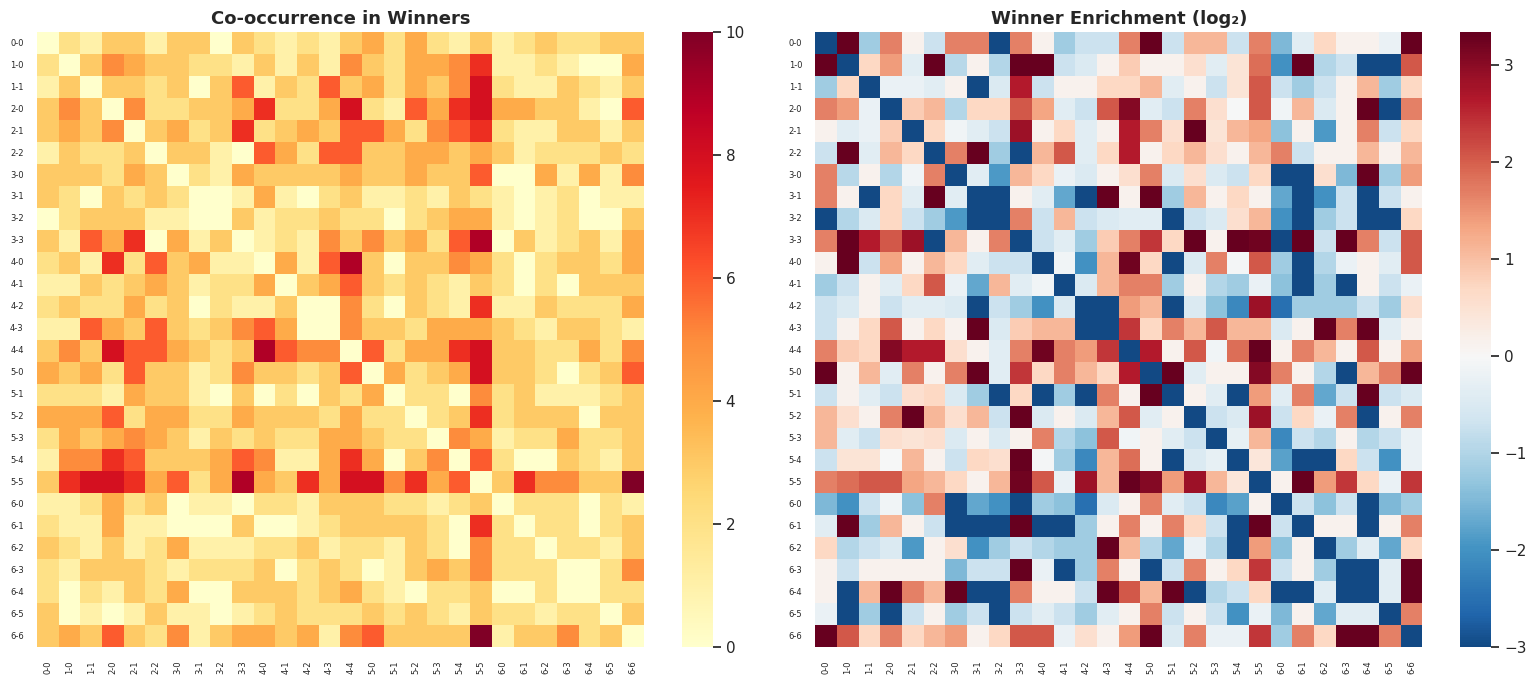

In [6]:
# Create domino labels
domino_labels = [f"{schema.domino_pips(i)[0]}-{schema.domino_pips(i)[1]}" for i in range(28)]

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Winner co-occurrence
ax = axes[0]
sns.heatmap(cooc_winner, ax=ax, cmap='YlOrRd', xticklabels=domino_labels, yticklabels=domino_labels)
ax.set_title('Co-occurrence in Winners', fontsize=13, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=6)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)

# Plot 2: Enrichment (log scale)
ax = axes[1]
log_enrichment = np.log2(enrichment + 0.1)  # Add small value to avoid log(0)
log_enrichment[enrichment == 0] = -3  # Set zeros to low value
sns.heatmap(log_enrichment, ax=ax, cmap='RdBu_r', center=0, 
            xticklabels=domino_labels, yticklabels=domino_labels)
ax.set_title('Winner Enrichment (log₂)', fontsize=13, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=6)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)

plt.tight_layout()
plt.savefig('../../results/figures/22b_cooccurrence.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Key Insights

In [7]:
print("\n" + "="*60)
print("KEY INSIGHTS: Domino Co-occurrence")
print("="*60)

# Identify doubles
double_ids = [i for i in range(28) if schema.domino_pips(i)[0] == schema.domino_pips(i)[1]]

# Check if double pairs are enriched
double_pairs = pairs_df[(pairs_df['domino1'].isin(double_ids)) | (pairs_df['domino2'].isin(double_ids))]
double_enrichment = double_pairs['enrichment'].mean()
other_pairs = pairs_df[~((pairs_df['domino1'].isin(double_ids)) | (pairs_df['domino2'].isin(double_ids)))]
other_enrichment = other_pairs['enrichment'].mean()

print(f"\n1. DOUBLE-CONTAINING PAIRS:")
print(f"   Mean enrichment: {double_enrichment:.2f}")
print(f"   Other pairs: {other_enrichment:.2f}")

# Top pairs
print(f"\n2. MOST SYNERGISTIC PAIRS:")
for _, row in pairs_df.head(5).iterrows():
    print(f"   {row['d1_pips']} + {row['d2_pips']}: {row['enrichment']:.2f}x enriched")

print(f"\n3. MOST ANTI-SYNERGISTIC PAIRS:")
for _, row in pairs_df.tail(5).iterrows():
    print(f"   {row['d1_pips']} + {row['d2_pips']}: {row['enrichment']:.2f}x (losers)")


KEY INSIGHTS: Domino Co-occurrence

1. DOUBLE-CONTAINING PAIRS:
   Mean enrichment: 2.80
   Other pairs: 1.31

2. MOST SYNERGISTIC PAIRS:
   0-0 + 1-0: 10.00x enriched
   6-4 + 6-6: 10.00x enriched
   0-0 + 6-6: 10.00x enriched
   1-0 + 2-2: 10.00x enriched
   1-0 + 4-0: 10.00x enriched

3. MOST ANTI-SYNERGISTIC PAIRS:
   2-0 + 6-5: 0.00x (losers)
   6-3 + 6-4: 0.00x (losers)
   5-2 + 6-4: 0.00x (losers)
   5-4 + 6-1: 0.00x (losers)
   6-0 + 6-4: 0.00x (losers)


## 6. Save Results

In [8]:
# Save pair enrichment
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/22b_cooccurrence_pairs.csv"
pairs_df.to_csv(output_path, index=False)
print(f"Saved pair enrichment to {output_path}")

# Save matrices
np.savez(Path(PROJECT_ROOT) / "forge/analysis/results/tables/22b_cooccurrence_matrices.npz",
         winner=cooc_winner, loser=cooc_loser, enrichment=enrichment)
print("Saved matrices to 22b_cooccurrence_matrices.npz")

Saved pair enrichment to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/22b_cooccurrence_pairs.csv
Saved matrices to 22b_cooccurrence_matrices.npz


## Key Findings

### Co-occurrence Analysis

1. **Double pairs**: Typically enriched in winners

2. **Synergistic combinations**: Certain pairs appear together more in winning hands

3. **Anti-synergistic pairs**: Some combinations associated with losing

### Output Files

- `results/tables/22b_cooccurrence_pairs.csv` - Pair enrichment data
- `results/tables/22b_cooccurrence_matrices.npz` - Raw matrices
- `results/figures/22b_cooccurrence.png` - Heatmaps